# Setup


This setup is tailored for runnning in Google Colab (some commands might have no effect on a plain jupyter session).
If you have already installed RDKit and the signaturizer you can skip to [next section](#basic)

Google’s updated their Colab instances to use TensorFlow 2.X by default. The last stable version of the Signaturizers is still on TensorFlow 1.X.

In [ ]:
%tensorflow_version 1.x

## Install RDKit

In [ ]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -q -y -c conda-forge rdkit

Add RDKit to system PATH

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

## Install the _signaturizer_ package

In [ ]:
!pip install signaturizer -U

In [1]:
import os
os.chdir('..')

import sys
import signaturizer
print(signaturizer.__file__)

/aloy/home/mbertoni/code/signaturizer/signaturizer/__init__.py


# <a name="basic"></a> Basic usage

## Generating Bioactivity Signatures

Let's start loading the signaturizer for `B1` space which generates the Mode of Action bioactivity descriptor. The MoA is represented by the exact molecular target/s or the physiological outcomes (if the target has not yet been elucidated or is subject to debate). 

The MoA of `Aspirin`, for example, would be `inhibitor of COX-1` while its broader mode of action would be `blocks prostaglandin synthesis`.

In [2]:
from signaturizer import Signaturizer
sign = Signaturizer('B1')

To generate signatures for a compound we need it's structure represented in [SMILES format](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system).

Let's take for example the smiles for three common pharmacy drugs:
-  _Aspirin_ : CC(=O)OC1=CC=CC=C1C(=O)O
-  _Lovastatin_ : CCC(C)C(=O)OC1CC(C=C2C1C(C(C=C2)C)CCC3CC(CC(=O)O3)O)C
-  _Simvastatin_ : CC(C)C1=C(C(=C(N1CCC(CC(CC(=O)O)O)O)C2=CC=C(C=C2)F)C3=CC=CC=C3)C(=O)NC4=CC=CC=C4

In [3]:
aspirin = 'CC(=O)OC1=CC=CC=C1C(=O)O'
lovastatin ='CCC(C)C(=O)OC1CC(C=C2C1C(C(C=C2)C)CCC3CC(CC(=O)O3)O)C'
simvastatin = 'CC(C)C1=C(C(=C(N1CCC(CC(CC(=O)O)O)O)C2=CC=C(C=C2)F)C3=CC=CC=C3)C(=O)NC4=CC=CC=C4'

In [4]:
smiles = [aspirin, lovastatin, simvastatin]
results = sign.predict(smiles)

In [5]:
print(results.signature.shape)

(3, 128)


In [6]:
print(results.signature)

[[-0.10735843 -0.09857366 -0.10543366  0.10548453 -0.10549589  0.10528049
   0.10317267 -0.05153803 -0.00418885  0.01363485 -0.0616022  -0.10474365
   0.106157   -0.10635745 -0.10553286 -0.03762896  0.08818265  0.10388952
   0.10228071 -0.02573126 -0.09235839 -0.10431267 -0.06914258 -0.08317238
   0.09777546  0.10451618 -0.01429815 -0.10665171 -0.10735557  0.01068052
   0.10485428 -0.10459466 -0.0465067   0.10161796  0.04915467  0.07926688
   0.02674097  0.10120027 -0.09563923  0.09616647 -0.10776384 -0.10688285
  -0.09917416 -0.07726933 -0.1067754   0.1016459  -0.07684016  0.03898009
  -0.07787929 -0.08747023 -0.05436514  0.01366165 -0.07764621 -0.09646145
  -0.10555495 -0.05729873  0.10049175 -0.09828803 -0.08078068  0.10453899
   0.09460763  0.10658664 -0.10221312 -0.10043798 -0.09282003 -0.10753073
  -0.09511212 -0.08432139  0.1006536  -0.09715015  0.05733466  0.07575393
  -0.10381117  0.09981636 -0.10713801 -0.10333582 -0.05963349  0.10702831
   0.03038718  0.09662336  0.10032459 

We can measure the distance between signatures to highlight that the two statins have indeed a similar MoA, which is different from that of _aspirin_.

In [7]:
from scipy.spatial.distance import euclidean
print(euclidean(results.signature[0], results.signature[1]))
print(euclidean(results.signature[0], results.signature[2]))
print(euclidean(results.signature[1], results.signature[2]))

0.998249351978302
0.9988548159599304
0.0060097710229456425


## Generating multiple Signatures in one batch

We might want to describe out molecules by multiple point of view using different descriptors. The signaturizer package allow easy and modular bioactivity space cambinations.

Signaturizers are loaded as TF hub modules so they are cached locally, in this way model download (which takes time) is happening only once

In [8]:
sign = Signaturizer(['B1', 'E4', 'A5', 'D3'])
results = sign.predict(smiles)
print(results.signature.shape)

(3, 512)


## Generating Global Bioactivity Signatures

A `GLOBAL` signature consists of stacking all the bioactivity spaces described by the Chemical Checker, this is convinient when we want a rich _general purpose_ descriptor.

In [9]:
sign = Signaturizer('GLOBAL')
results = sign.predict(smiles)
print(results.signature.shape)

(3, 3200)


## Saving results to h5

When generating signatures for a lot of molecules it is better to save them to disk and avoid consuming all system memory.

In [10]:
!rm destination.h5
results = sign.predict(smiles, 'destination.h5')

rm: cannot remove 'destination.h5': No such file or directory


We can read the results anytime using the [h5py package](https://www.h5py.org/).

In [11]:
import h5py
with h5py.File('destination.h5', 'r') as fh:
  signatures = fh['signature'][:]
print(signatures.shape)

(3, 3200)


## Applicability predictions

The `applicability` score helps identifying molecules for which the signature prediction is extremely accurate.

In [12]:
results = sign.predict(smiles, applicability=True)

Each bioactivity signature comes with an applicability score, and since we are using the global signature, we will have 25 applicability score for each molecule.

In [13]:
print(results.applicability.shape)

(3, 25)


NB: In `results.dataset` we store the bioactivity dataset code.

In [14]:
print(results.dataset)

['A1' 'A2' 'A3' 'A4' 'A5' 'B1' 'B2' 'B3' 'B4' 'B5' 'C1' 'C2' 'C3' 'C4'
 'C5' 'D1' 'D2' 'D3' 'D4' 'D5' 'E1' 'E2' 'E3' 'E4' 'E5']


We can highligth most reliable predictions (applicability is tuned as measure of correlation, i.e. how much we think the signature is related to real values)

In [15]:
%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

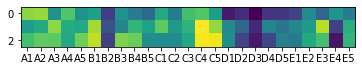

In [16]:
plt.imshow(results.applicability)
plt.gca().set_xticks(range(len(results.dataset)));
plt.gca().set_xticklabels(results.dataset);

# Usage example

## Data source
In this notebook we will analize a representative subset of the [FooDB](https://foodb.ca/) compound library exploiting the Chemical Checker signatures generated _via_ our Signaturizers. Let's first download and inspect the  data:

In [17]:
!wget http://gitlabsbnb.irbbarcelona.org/packages/signaturizer/raw/master/notebook/foodb_repr.csv

--2020-07-16 15:47:59--  http://gitlabsbnb.irbbarcelona.org/packages/signaturizer/raw/master/notebook/foodb_repr.csv
Resolving gitlabsbnb.irbbarcelona.org (gitlabsbnb.irbbarcelona.org)... 84.88.74.140
Connecting to gitlabsbnb.irbbarcelona.org (gitlabsbnb.irbbarcelona.org)|84.88.74.140|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5535132 (5.3M) [text/plain]
Saving to: ‘foodb_repr.csv’

foodb_repr.csv      100%[===================>]   5.28M  --.-KB/s    in 0.06s   

2020-07-16 15:47:59 (89.9 MB/s) - ‘foodb_repr.csv’ saved [5535132/5535132]



In [18]:
import pandas as pd
df = pd.read_csv('./foodb_repr.csv')
df

,InChIKey,SMILES,food_name,food_subgroup,food_group
0,AAARRLVSWMMLIL-JFDCHTIYSA-N,CC/C=C\C/C=C\C/C=C\C/C=C\CCCCCCC(=O)OC[C@H](CO...,Bison,Bovines,Animal foods
1,AAAUQAJYMBAEDN-SDYYSCIWSA-N,CC/C=C\C/C=C\C/C=C\C/C=C\CCCCCCC(=O)OC[C@H](CO...,Bison,Bovines,Animal foods
2,AAAVAOYFDZROJH-ODEQYEIHSA-N,CCCCCCCCCCCCCCCCC(=O)OC[C@@H](COC(=O)CCCCCCCCC...,Bison,Bovines,Animal foods
3,AAAYFFAGXKLUDV-AXAMJWTMSA-N,CC(C)CCCCCCCCCCCCCCCCCC(=O)OC[C@H](COC(=O)CCCC...,Bison,Bovines,Animal foods
4,AABORWYRSOFPIQ-NTOMMRJQSA-N,CCCCCCCCCCCCCCCCCCC(=O)OC[C@@H](COC(=O)CCCCCCC...,Bison,Bovines,Animal foods
...,...,...,...,...,...
47949,IKGXIBQEEMLURG-NVPNHPEKSA-N,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)...,Berry wine,Fermented beverages,Beverages
47950,IKGXIBQEEMLURG-NVPNHPEKSA-N,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)...,Berry wine,Fermented beverages,Beverages
47951,OXGUCUVFOIWWQJ-HQBVPOQASA-N,C[C@@H]1O[C@@H](Oc2c(-c3ccc(O)c(O)c3)oc3cc(O)c...,Berry wine,Fermented beverages,Beverages
47952,OXGUCUVFOIWWQJ-HQBVPOQASA-N,C[C@@H]1O[C@@H](Oc2c(-c3ccc(O)c(O)c3)oc3cc(O)c...,Berry wine,Fermented beverages,Beverages


We have different column in this file, the most important for our task is the **SMILES** columns, which is the input required to generate signatures.

In [19]:
df.nunique()

InChIKey         6325
SMILES           6325
food_name         461
food_subgroup      57
food_group         17
dtype: int64

Comparing the total number of rows (47954) to the number of unique entries (6325) we realize that molecules are repeated, and indeed different food can contain repeated compounds. For this reason we'll use a non redundant set of SMILES.

In [20]:
smiles = df.SMILES.unique()

## Signatures
Signatures are numerical representation of molecules. Having molecules represented as vector is needed if we want to do any quantitative analysis of our library (e.g. comparison, clustering, visualization ...). The advantage of using a signaturizer with respect to standard chemical representation (e.g. morgan fingerprint) is that we can leverage on the wealth of public bioactivity data that goes beyond chemical information.

In the Chemical Checker we defined 25 bioactivity spaces which capture multiple aspect of a molecule. The stacked version of the signatures for these 25 spaces is what we call the _global_ signature, i.e. a general purpose entry point for our analisys.

In [21]:
# load the global bioactivity signaturizer
from signaturizer import Signaturizer
sign = Signaturizer('GLOBAL')

For the sake of time we can just consider a random subsampling of these molecules.

In [22]:
import numpy as np
np.random.seed(42)
subsample = np.random.choice(smiles, 1000, replace=False)
result = sign.predict(subsample)

In [23]:
result.signature.shape

(1000, 3200)

## Visualization
Only imagination limits us in the way we can visualize the results generated.

In [24]:
%matplotlib inline
import matplotlib
import seaborn as sns
from matplotlib import gridspec, colors, colorbar, patches, lines
import matplotlib.pyplot as plt

We can plot the overall distribution of values for all generated signatures, and appreciate their bimodal distribution.

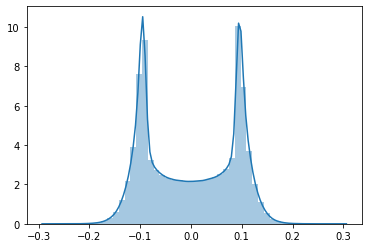

In [25]:
sns.distplot(result.signature.ravel())

Or we can take a peek at the raw matrix.

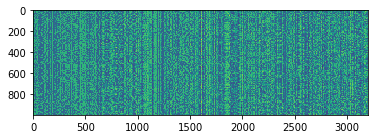

In [26]:
plt.imshow(result.signature)

The signatures we generated have 3200 dimensions but looking at the raw data does not inform us on how similar/different are our molecules.

In Cheminformatics we often need a graphical representation of the chemical space covered by a set of molecules.  In this representation, similar molecules will be close and molecules that are different will be far apart.

We can use scikit-learn to create a lower bi-dimensional representation which will enable such visualization.

In [27]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
pca = PCA(n_components=128)
pca_red = pca.fit_transform(result.signature)
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))
projection = TSNE(n_components=2).fit_transform(pca_red)

[0.1009716  0.08374351 0.07335763 0.05303324 0.03183838 0.02693985
 0.02340496 0.01879136 0.01696455 0.01524393 0.01353733 0.01303552
 0.01151096 0.01045635 0.00965904 0.00890174 0.00852792 0.00827977
 0.00784791 0.00719183 0.0066917  0.00638146 0.00627409 0.0062519
 0.0059248  0.00577865 0.00553676 0.00548767 0.00514282 0.00510978
 0.00506704 0.00484388 0.0047338  0.00463202 0.00432434 0.00427178
 0.00419819 0.00411115 0.00404599 0.00397378 0.00381135 0.00375953
 0.00362983 0.00352418 0.00344605 0.00333815 0.0032779  0.00322194
 0.00316193 0.00304856 0.00300883 0.00295838 0.00290536 0.00289234
 0.00284705 0.00280468 0.0027715  0.00269688 0.00263287 0.00262257
 0.00257502 0.00251739 0.00249343 0.00247622 0.00244484 0.00239713
 0.00237753 0.00231684 0.00230882 0.00228376 0.0022372  0.00220344
 0.00218776 0.00216175 0.00213112 0.00210671 0.00206982 0.00204193
 0.00203523 0.00200114 0.00197163 0.00196186 0.00194344 0.00192958
 0.0018796  0.00185302 0.00183038 0.00180847 0.00179144 0.00178

In [28]:
print(projection.shape)

(1000, 2)


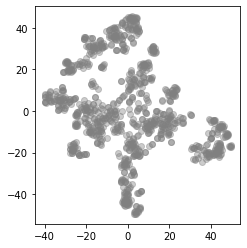

In [29]:
plt.scatter(projection[:,0],projection[:,1], color='grey', alpha=.4)
plt.gca().set_aspect('equal')

Now we can appreciate the diversity of our molecules and also that they are 'organized' with some form of structure. We can annotate molecules with the food of origin to highlight this structure.

For example let's color all molecules coming from animal origin (i.e. meat):

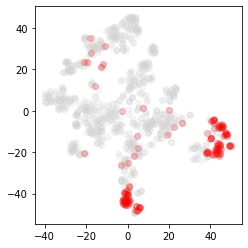

In [30]:
cat_smiles = df[df.food_group == 'Animal foods'].SMILES.unique()
cat_mask = np.isin(subsample, cat_smiles)
plt.scatter(projection[:,0],projection[:,1], color='lightgrey', alpha=.2)
plt.scatter(projection[:,0][cat_mask],projection[:,1][cat_mask], color='red', alpha=0.2)
plt.gca().set_aspect('equal')

We clearly see that molecules from this food source are localized in two clusers of our bioactivity space.

If we go for compounds of vegetable orgin we can see, as expectable, that the two set of molecules do not overlap.

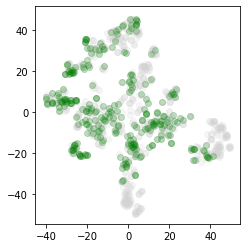

In [31]:
cat_smiles = df[df.food_group == 'Vegetables'].SMILES.unique()
cat_mask = np.isin(subsample, cat_smiles)
plt.scatter(projection[:,0],projection[:,1], color='lightgrey', alpha=.2)
plt.scatter(projection[:,0][cat_mask],projection[:,1][cat_mask], color='green', alpha=0.2)
plt.gca().set_aspect('equal')